The goal of this notebook is to create a datacube across different rasters of remotely sensed data with different coordinate reference systems and resolutions. Specifically, the new set of rasters will all have the same size and each pixel across the rasters will all correspond to the same geographic area.

All the data we have is in `data/tifs`. In this notebook, we will select a subset the area using one of the tifs and reproject all the other rasters into the same subset with identical `crs` and `geotransform`.

This notebook is *optional* and can be used to apply the methods found here to different study areas.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import sys
sys.path.append('../../rscube')
from rio_tools import get_cropped_profile, reproject_arr_to_match_profile

# Data Paths

In [2]:
data_path_name = 'data/tifs'
data_path = Path(data_path_name)
data_path.exists()

True

In [3]:
tif_paths = sorted(list(data_path.glob('*.tif')))
tif_paths

[PosixPath('data/tifs/ALOS_RTC_2009_06_30_HH.tif'),
 PosixPath('data/tifs/ALOS_RTC_2009_06_30_HV.tif'),
 PosixPath('data/tifs/Hansen_GFC2015_last_10N_000E.tif'),
 PosixPath('data/tifs/Hansen_GFC2015_treecover2000_10N_000E.tif')]

In [4]:
dest_dir_name = 'data/tif_datacube'
dest_dir = Path(dest_dir_name)
dest_dir.mkdir(exist_ok=True, parents=True)

# Inspect the Data

In [5]:
with rasterio.open(tif_paths[0]) as ds:
    hh = ds.read(1)
    profile = ds.profile

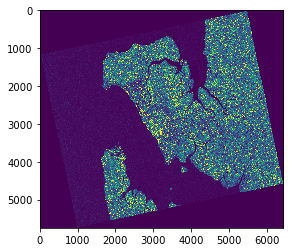

In [6]:
plt.imshow(hh, vmin=0, vmax=.5)

We are going to reproject the data into a subset.

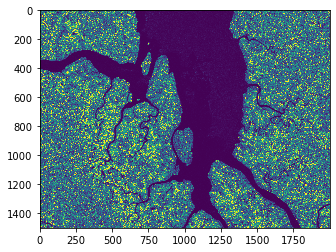

In [7]:
sy = np.s_[1000: 2500]
sx = np.s_[3000: 5000]

plt.imshow(hh[sy, sx], vmin=0, vmax=.5)

In [8]:
cropped_profile = get_cropped_profile(profile, sx, sy)

# Reproject All

We write a function to reproject one raster and then apply to each raster in our folder. We use the function `reproject_arr_to_match_profile` which takes the metadata stored in the `rasterio` profile and makes sure the other rasters match that geographic metadata. The rest of the function is io and making sure the new rasters are saved to the desired location.

In [9]:
def reproject_one(path):
    with rasterio.open(path) as ds:
        arr = ds.read()
        src_profile = ds.profile
    
    arr_r, profile_r = reproject_arr_to_match_profile(arr, src_profile, cropped_profile)
    
    dest_path = dest_dir/path.name
    with rasterio.open(dest_path, 'w', **profile_r) as ds:
        ds.write(arr_r)

    return dest_path

In [10]:
# We have this to make sure the above function works as expected
#reproject_one(tif_paths[0])

# This is equivalent to
# [reproject_path(path) for path in tif_paths]
list(map(reproject_one, tqdm(tif_paths)))

100%|██████████| 4/4 [00:41<00:00, 10.27s/it]


[PosixPath('data/tif_datacube/ALOS_RTC_2009_06_30_HH.tif'),
 PosixPath('data/tif_datacube/ALOS_RTC_2009_06_30_HV.tif'),
 PosixPath('data/tif_datacube/Hansen_GFC2015_last_10N_000E.tif'),
 PosixPath('data/tif_datacube/Hansen_GFC2015_treecover2000_10N_000E.tif')]